This file is used to generate Fig S5

First, a random discrete random loci model is instantiated, then an adaptive dynamics model is made with a trade-off function fitted to the simulated pareto front.

In [520]:
import numpy as np
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from model import PModel, ADModel

#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

#Parameters for evolutionary simulation
n_gens = 15
t = (0, 1000)

In [521]:
def pareto_front(sim, n_steps=100):
	cost = np.zeros(n_steps)
	beta = np.linspace(0, np.max(sim.B), n_steps)

	for i, val in enumerate(beta):
		cost[i] = np.max((sim.F)[sim.B <= val])
		
	return (beta, cost)

In [522]:
#Initialize discrete random loci model
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

PF_model = PModel(n_loci, res, cost, beta=beta)
PF_model.normalize()

#Compute pareto front and interpolate from model
res_vals = np.linspace(0, np.max(PF_model.B), 100)
res_pts, fec_pts = PF_model.pareto()
fec_interp = np.interp(res_vals, res_pts, fec_pts)

coefs = np.polyfit(res_vals, fec_interp, 5)
fec_vals = np.poly1d(coefs)(res_vals)

In [523]:
#Initialize an adaptive dynamics model based on the trade-off function
AD_sim = ADModel(res=res_vals, b=fec_vals)
results = AD_sim.run_sim()

#run dynamical simulation
X_t, I_t = PF_model.run_sim(t, n_gens)

In [524]:
#Resample results into time and genotype bins to create a raster
n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, PF_model.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < PF_model.B,PF_model.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

t_ticks = np.linspace(0, 1, 7)*n_time_bins
t_tick_labels = np.linspace(0, n_gens, 7, dtype=np.uint)

r_ticks = np.linspace(0, 1, 5)*n_res_bins
r_tick_labels = np.linspace(1, 0, 5)

Text(-0.2, 1.1, 'C')

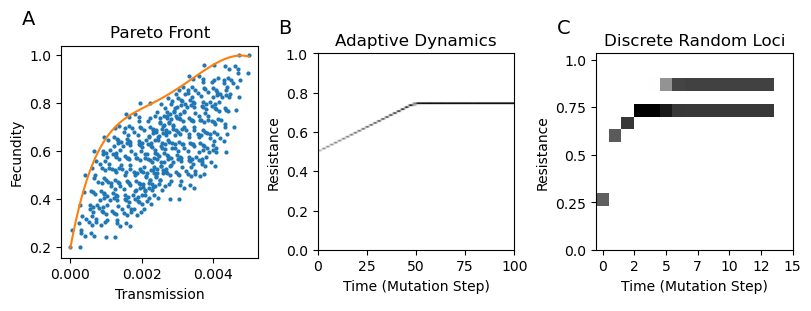

In [525]:
fig, ax = plt.subplots(ncols=3, figsize=(8, 3), layout='constrained')

ax[0].scatter(PF_model.B, PF_model.F, s=4)
ax[0].plot(res_vals, fec_vals, color='tab:orange')
ax[0].set_title('Pareto Front')
ax[0].set_ylabel('Fecundity')
ax[0].set_xlabel('Transmission')

ax[1].imshow(results[0], extent=[0,1,0,1], cmap='Greys')
ax[1].set_title('Adaptive Dynamics')
ax[1].set_ylabel('Resistance')
ax[1].set_xlabel('Time (Mutation Step)')
ax[1].set_xticks(np.linspace(0, 1, 5))
ax[1].set_xticklabels(np.linspace(0, 100, 5, dtype=np.uint))

genotypes = ax[2].imshow(np.log(1+evol_plot), cmap='Greys')
ax[2].set_title('Discrete Random Loci')
ax[2].set_ylabel('Resistance')
ax[2].set_xlabel('Time (Mutation Step)')
ax[2].set_xticks(t_ticks)
ax[2].set_yticks(r_ticks)
ax[2].set_xticklabels(t_tick_labels)
ax[2].set_yticklabels(r_tick_labels)

ax[0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[2].annotate("C", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)

Invasion plots

In [526]:
def label_ticks(ax, vals, n_ticks = (4, 4)):
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    x_ticks = np.linspace(x_lim[0], x_lim[1], n_ticks[0])
    y_ticks = np.linspace(y_lim[0], y_lim[1], n_ticks[1])

    x_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks[0]), 3)
    y_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks[1]), 3)

    ax.set_xticks(x_ticks, x_tick_labels)
    ax.set_yticks(y_ticks, y_tick_labels)

In [527]:
def S_star(beta, mu=0.2):
    return mu / beta

def I_star(beta, b, mu=0.2, k=0.001):
    return (beta*(b - mu) - k*mu) / (beta*(k + beta))

def invasion_fitness(b_res, beta_res, b_mut, beta_mut, mu=0.2, k=0.001):
    return b_mut - mu - k*(S_star(beta_res) + I_star(beta_res, b_res)) - beta_mut*I_star(beta_res, b_res)

In [532]:
dim = 1000

PIP = np.zeros((dim, dim))

res_vals = np.linspace(0.0001, np.max(PF_model.B), dim)
res_pts, fec_pts = PF_model.pareto()
fec_interp = np.interp(res_vals, res_pts, fec_pts)

coefs = np.polyfit(res_vals, fec_interp, 5)
fec_vals = np.poly1d(coefs)(res_vals)

for i in range(dim):
    for j in range(dim):
        PIP[i, j] = invasion_fitness(fec_vals[i], res_vals[i], fec_vals[j], res_vals[j])

Text(-0.2, 1.1, 'B')

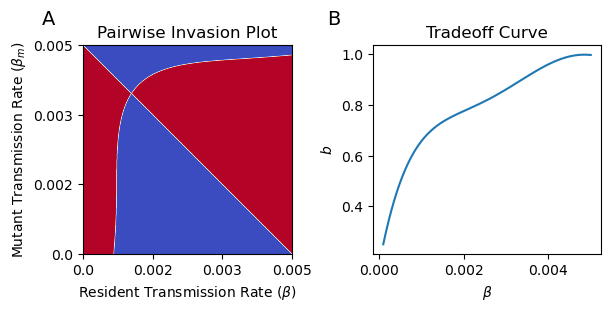

In [534]:
PIP[PIP > 0] = 1
PIP[PIP <= 0] = -1

fig, ax = plt.subplots(ncols=2, figsize=(6, 3), layout='constrained')

ax[0].imshow(PIP.T, cmap='coolwarm')

label_ticks(ax[0], res_vals)

ax[0].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[0].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

ax[1].plot(res_vals, fec_vals)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$b$')

ax[0].set_title('Pairwise Invasion Plot')
ax[1].set_title('Tradeoff Curve')

ax[0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)